In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
from matplotlib.colors import LogNorm
import cPickle as pickle

In [2]:
import pyathena.yt_analysis.plot_projection as pproj
reload(pproj)

C:\anaconda2\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'pyathena.yt_analysis.plot_projection' from 'pyathena\yt_analysis\plot_projection.pyc'>

In [3]:
from pyathena.yt_analysis.plot_projection import *

In [8]:
base='D:/yeongu/'
problem_id='RPS_8pc_ICM2'

for itime in range(250,260):
    surfname='{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime)
    scalname='{}{}/surf/{}.{:04d}.scal4.p'.format(base,problem_id,problem_id,itime)
    starname='{}{}/starpar/{}.{:04d}.starpar.vtk'.format(base,problem_id,problem_id,itime)


    fig=pproj.plot_projection_icm(surfname,scalname,starname,stars=True,writefile=True,runaway=False)

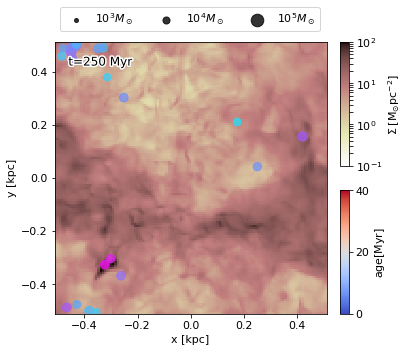

In [67]:
base='D:/yeongu/'
problem_id='RPS_8pc_ICM2'

for itime in range(250,257):
    surfname='{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime)
    starname='{}{}/starpar/{}.{:04d}.starpar.vtk'.format(base,problem_id,problem_id,itime)

    fig=pproj.plot_projection(surfname,starname,stars=True,writefile=False,runaway=False)

In [1]:
import glob
import os
import matplotlib.colorbar as colorbar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm,NoNorm,Normalize
import numpy as np

import pyathena.yt_analysis.ytathena as ya
from pyathena import read_starvtk,texteffect,set_units
from pyathena.yt_analysis.scatter_sp import scatter_sp

def plot_projection_all(surfnames,axis='y',pngfname=None,runaway=True,icm_max=1.0,iscal=-1,norm_factor=1.0):

    plt.rc('font',size=30)
    plt.rc('xtick',labelsize=30)
    plt.rc('ytick',labelsize=30)

    nsurf=len(surfnames)
    setup=True
    for i,surfname in enumerate(surfnames):
        aux=ya.set_aux(os.path.basename(surfname))
        scalfnames=glob.glob(surfname.replace('surf.p','scal?.p'))
        scalfnames.sort()
        starfnames=glob.glob(surfname.replace('surf/','starpar/').replace('surf.p','starpar.vtk'))+glob.glob(surfname.replace('surf/','id0/').replace('surf.p','starpar.vtk'))
        nstar=len(starfnames)
        nscal=len(scalfnames)
       
        if nstar > 0:
            starfname=starfnames[0]
            sp=read_starvtk(starfname)
        
        frb=pickle.load(open(surfname,'rb'))
        if nscal > 0:
            icm=pickle.load(open(scalfnames[iscal],'rb'))
            if icm[axis]['data'].max() > (icm_max*1.1):
                print scalfnames[iscal],icm[axis]['data'].min(),icm[axis]['data'].max()

        if 'time' in frb:
            tMyr=frb['time']
        else:
            time,sp=read_starvtk(starfname,time_out=True)
            tMyr=time*Myr
 
        if setup:
            extent=np.array(frb[axis]['bounds'])/1.e3
            x0=extent[0]
            y0=extent[2]
            Lx=extent[1]-extent[0]
            Lz=extent[3]-extent[2]
  
            if axis == 'z': ix=6
            else: ix=3
            iz=ix*Lz/Lx

            cism=plt.cm.bone_r #bone_r
            cicm=plt.cm.Reds #plt.cm.Reds
            cicm._init()
            x=np.arange(cicm.N)
            alphas=0.4*(np.tanh((x-100)/50.)+1)
            #alphas = np.linspace(0.5, 0.5, cicm.N)
            cicm._lut[:-3,-1] = alphas
            cicm._lut[-3,-1] = alphas.min()
            cicm._lut[-2,-1] = alphas.max()
  
            clim=aux['surface_density']['clim']
            cmin=clim[0]
            cmax=clim[1]
            if axis!='z': clim=(cmin*0.01,cmax)
            clim_icm=(0.0,0.5)
            norm_icm=Normalize()

            fig=plt.figure(0,figsize=(ix*nsurf+0.5,iz))
            width_list=[1]*nsurf+[0.1]
            gs = gridspec.GridSpec(3,nsurf+1,width_ratios=width_list,wspace=0.0)
            setup=False

        ax1=plt.subplot(gs[:,i])
        im1=ax1.imshow(frb[axis]['data'],norm=LogNorm(),origin='lower')
        im1.set_extent(extent)
        im1.set_cmap(cism)
        im1.set_clim(clim)

        if nscal > 0:
            icm[axis]['data'] /= icm_max
            im11=ax1.imshow(icm[axis]['data'],norm=norm_icm,origin='lower')
            im11.set_extent(extent)
            im11.set_cmap(cicm) #iccm
            im11.set_clim(clim_icm)

        if nstar > 0: 
            scatter_sp(sp,ax1,axis=axis,runaway=runaway,type='surf',norm_factor=norm_factor)

        if i==0:
            ax1.set_title('t=%3dMyr' % tMyr,**(texteffect(30)))
        else:
            ax1.set_title('%3dMyr' % tMyr,**(texteffect(30)))

    axes=fig.axes[:nsurf]
    ax1=axes[-1]
    cax=plt.subplot(gs[0,nsurf])
    cbar = fig.colorbar(im1,cax=cax,orientation='vertical')
    cbar.set_label(aux['surface_density']['label'])

    cax=plt.subplot(gs[1,nsurf])
    cbar = fig.colorbar(im11,cax=cax,orientation='vertical')
    cbar.set_label(r'$C_{\rm ICM}$')

    if nstar > 0:
        cax=plt.subplot(gs[2,nsurf])
        cbar = colorbar.ColorbarBase(cax, ticks=[0,20,40],
             cmap='coolwarm', norm=Normalize(vmin=0,vmax=40), 
             orientation='vertical')
        cbar.set_label(r'${\rm age [Myr]}$')

        s1=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e3)/norm_factor,color='k',
        alpha=.8,label=r'$10^3 M_\odot$')
        s2=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e4)/norm_factor,color='k',
        alpha=.8,label=r'$10^4 M_\odot$')
        s3=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e5)/norm_factor,
        color='k',alpha=.8,label=r'$10^5 M_\odot$')

        starlabels=(r'$10^3 M_\odot$',r'$10^4 M_\odot$',r'$10^5 M_\odot$') 
        if axis=='z':
            legend=ax1.legend((s1,s2,s3),starlabels,
                            loc='upper left',ncol=3,bbox_to_anchor=(0.0, 1.15),
                            fontsize='medium',frameon=True)
        else:
            legend=ax1.legend((s1,s2,s3),starlabels,
                            loc='lower right',fontsize='medium',frameon=True)


    plt.setp(axes,'xlim',(x0,x0+Lx))
    plt.setp(axes,'ylim',(y0,y0+Lz))

    ax1=axes[0]
    if axis=='z':
        plt.setp(axes,'xlabel','x [kpc]')
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('y [kpc]')
    elif axis=='y':
        plt.setp(axes,'xlabel','x [kpc]')
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('z [kpc]')
    elif axis=='x':
        plt.setp(axes,'xlabel','y [kpc]')
        ax1.set_ylabel('y [kpc]')
        ax1.set_ylabel('z [kpc]')


    plt.setp([ax.get_yticklabels() for ax in axes[1:]],visible=False)
    plt.setp([ax.get_xticklabels() for ax in axes[1:]],visible=False)

    if pngfname is not None:
        #plt.savefig(pngfname,bbox_inches='tight',num=0,dpi=500)
        plt.show()
        plt.close()
    else:
        return fig


C:\anaconda2\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
aux=ya.set_aux()

In [3]:
aux['surface_density']

{'clim': (0.1, 100),
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x6cdc978>,
 'label': '$\\Sigma\\;[{\\rm M}_{\\odot} {\\rm pc}^{-2}]$',
 'log': True}

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
from matplotlib.colors import LogNorm
import cPickle as pickle
from pyathena.yt_analysis.scatter_sp import scatter_sp

In [6]:
import pyathena.yt_analysis.plot_projection as pproj
reload(pproj)

<module 'pyathena.yt_analysis.plot_projection' from 'pyathena\yt_analysis\plot_projection.pyc'>

In [7]:
from pyathena.yt_analysis.plot_projection import *

7.085552799899663e-05 3.448897269688726
3.636523105490408e-05 2.427574030492258
5.493432640918505e-05 5.632574540206382
8.763551466287491e-05 3.21483880037882
0.00020076371210583888 4.882732816885189
6.468328140663548e-05 4.747210855657179
4.404765824657647e-05 3.079738077236116
1.5491764386033522e-05 3.3042510377259866
1.1366867346265084e-05 5.26601878058579
7.430381252909342e-05 1.9632075371271747
7.8100618688337e-05 3.1833191141991586
0.00014959322753938995 4.016141902972622
0.0001423687449295892 4.887012191182701
0.00011584328018196348 2.8854151161224646
0.00017253911123779416 3.0538025446177564
0.00016132733854884644 2.6058553127712276
0.0002010580502892663 3.1537960804319543


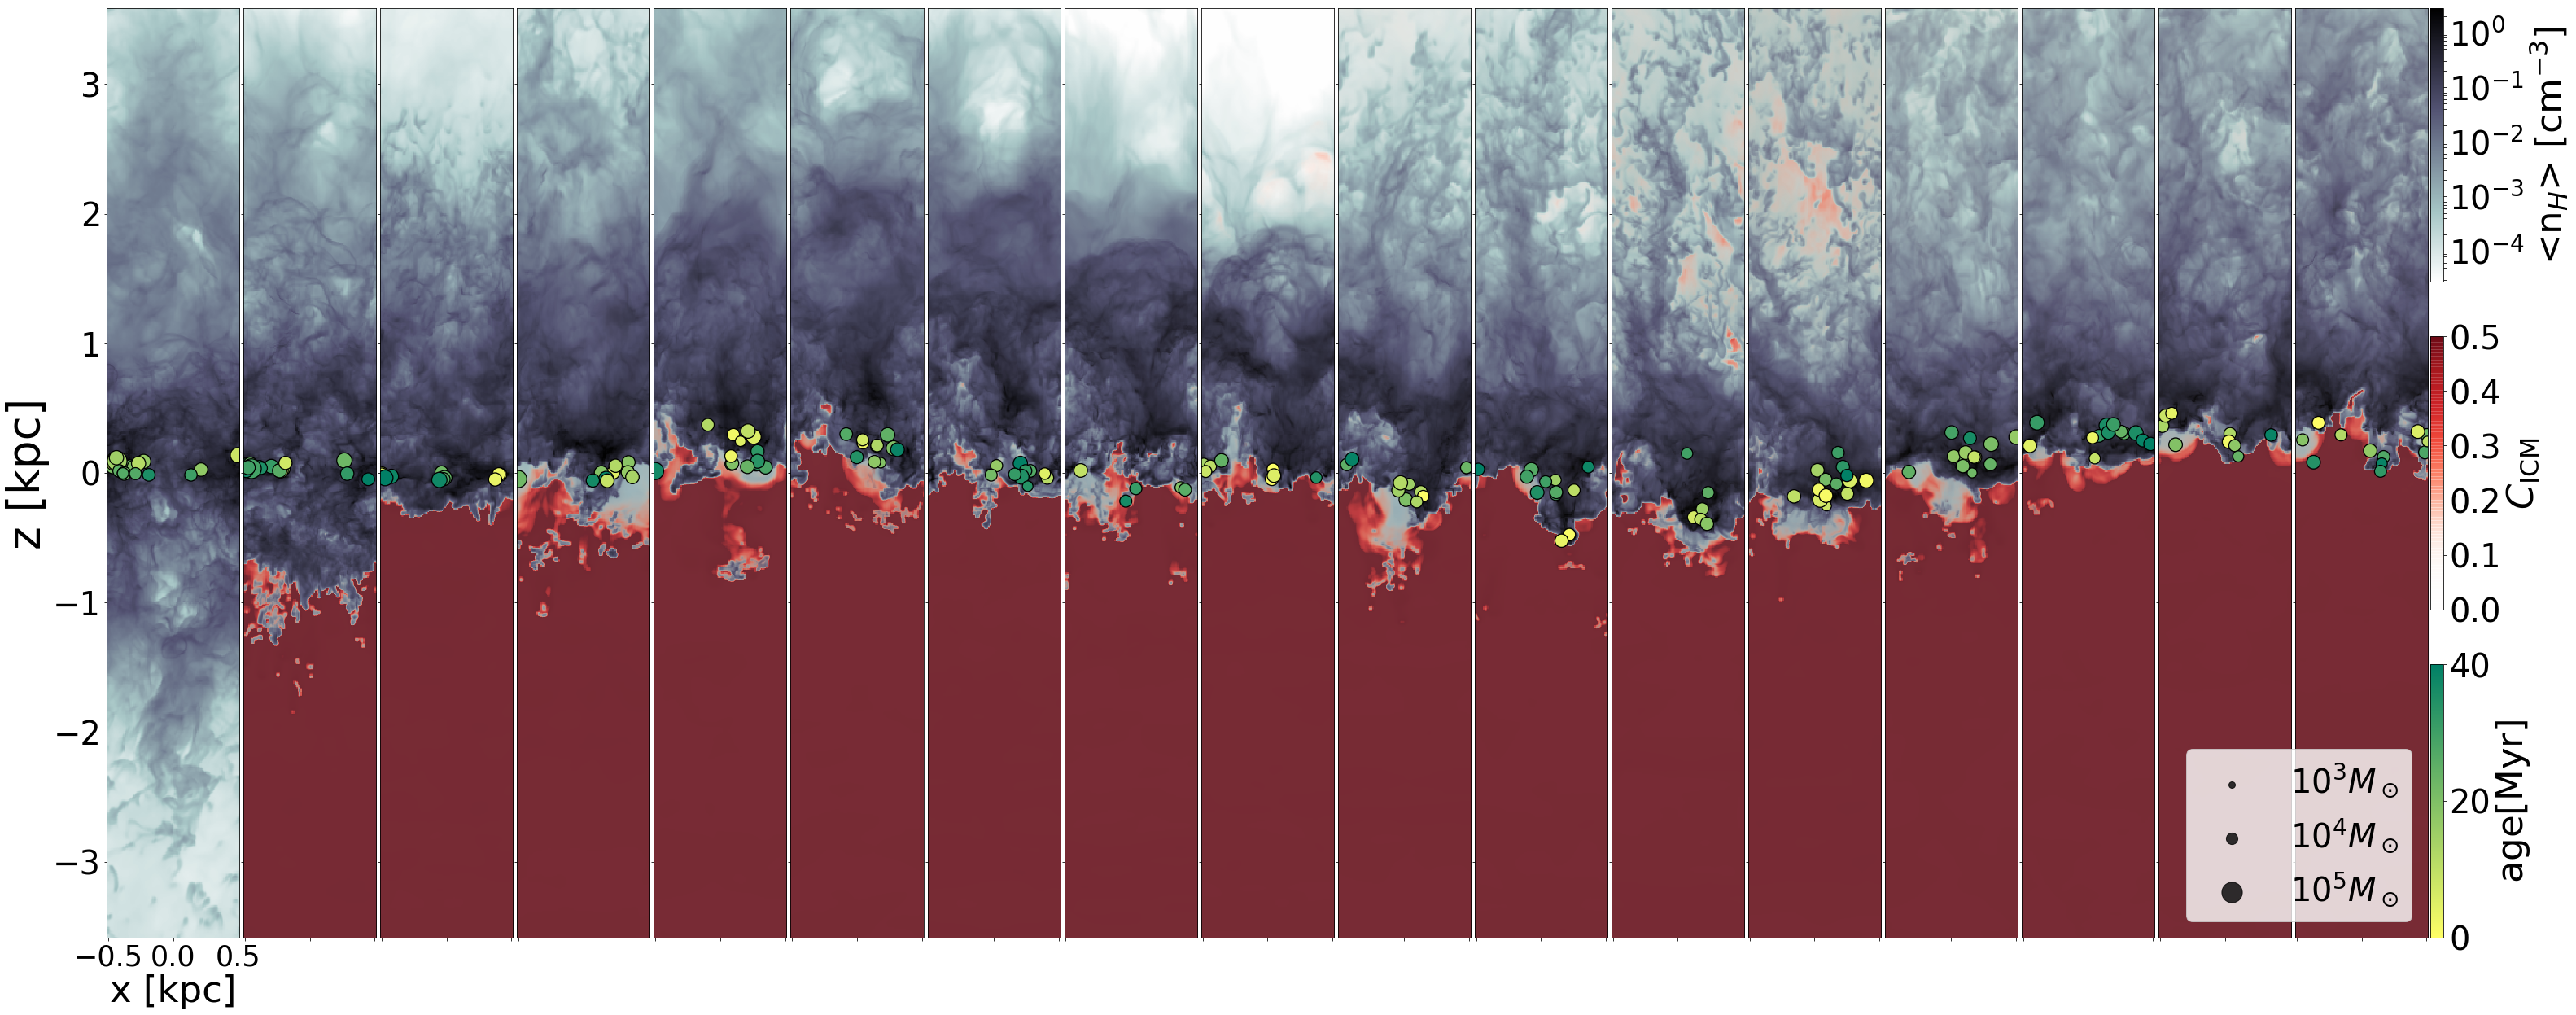

In [10]:
base='F:/yeongu/'
problem_id='RPS_8pc_ICM1'#'R8_8pc_metal'

surfnames=[]
for itime in range(250,500,15):
    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))

fig=plot_projection_all(surfnames,axis='y',runaway=False,iscal=4,norm_factor=0.5)#,pngfname='surf_%s_alpha1_5_notrans.png' % problem_id)

7.0855527999e-05 3.44889726969
3.63652310549e-05 2.42757403049
5.49343264092e-05 5.63257454021
8.76355146629e-05 3.21483880038
0.000200763712106 4.88273281689
6.46832814066e-05 4.74721085566
4.40476582466e-05 3.07973807724
1.5491764386e-05 3.30425103773
1.13668673463e-05 5.26601878059
7.43038125291e-05 1.96320753713
7.81006186883e-05 3.1833191142
0.000149593227539 4.01614190297
0.00014236874493 4.88701219118
0.000115843280182 2.88541511612
0.000172539111238 3.05380254462
0.000161327338549 2.60585531277
0.000201058050289 3.15379608043


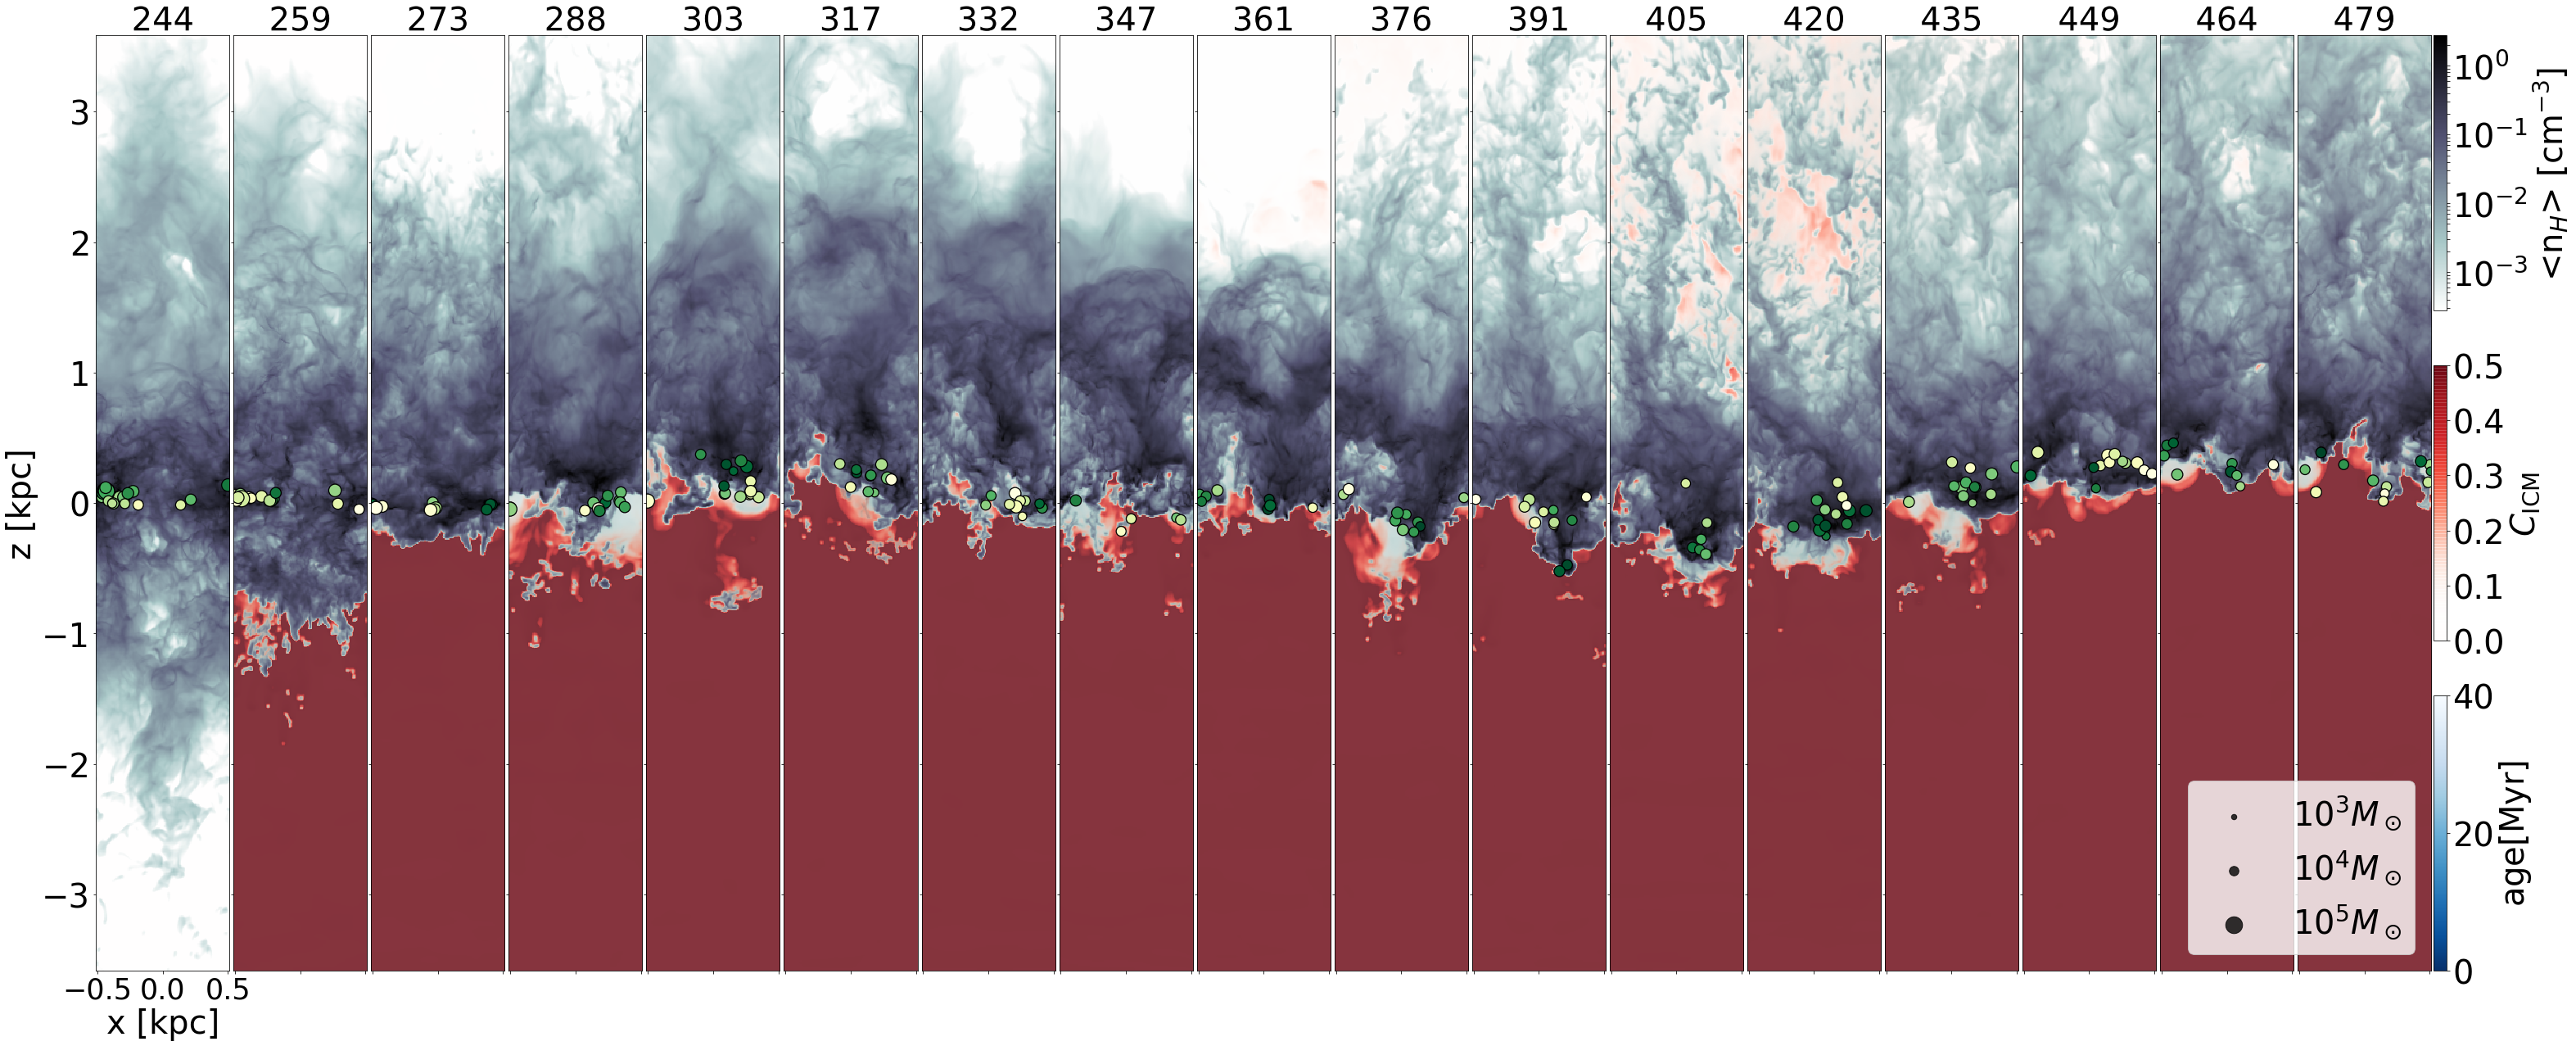

In [8]:
base='D:/yeongu/'
problem_id='RPS_8pc_ICM1'

surfnames=[]
for itime in range(250,500,15):
    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))

fig=plot_projection_all(surfnames,axis='y',runaway=False,iscal=4,norm_factor=0.75)#,pngfname='surf_%s_alpha1_5_notrans.png' % problem_id)

In [1]:
base='D:/yeongu/'
problem_id='RPS_8pc_ICM2'

surfnames=[]
for itime in range(250,500,15):
    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))

fig=plot_projection_all(surfnames,axis='y',runaway=False,iscal=4,norm_factor=0.75)#,pngfname='surf_%s_alpha1_5_notrans.png' % problem_id)

NameError: name 'plot_projection_all' is not defined

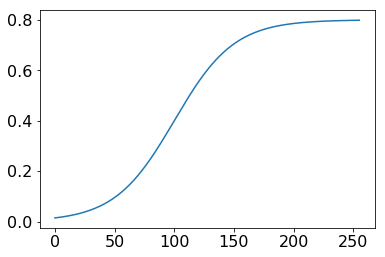

In [58]:
x=np.arange(256)
alphas=0.4*(np.tanh((x-100)/50.)+1)
plt.plot(alphas)

250
265
280
295
310
325
340
355
370
385
400
415
430
445
460
475
490
124.616898023
77.8329474728
131.514705144
102.665825493
90.530283535
164.709156327
216.320346427
131.63340484
105.208625669
189.983188865
126.843396665
163.142058711
158.937531613
121.943719377
120.554669449
115.141149333
103.693838431


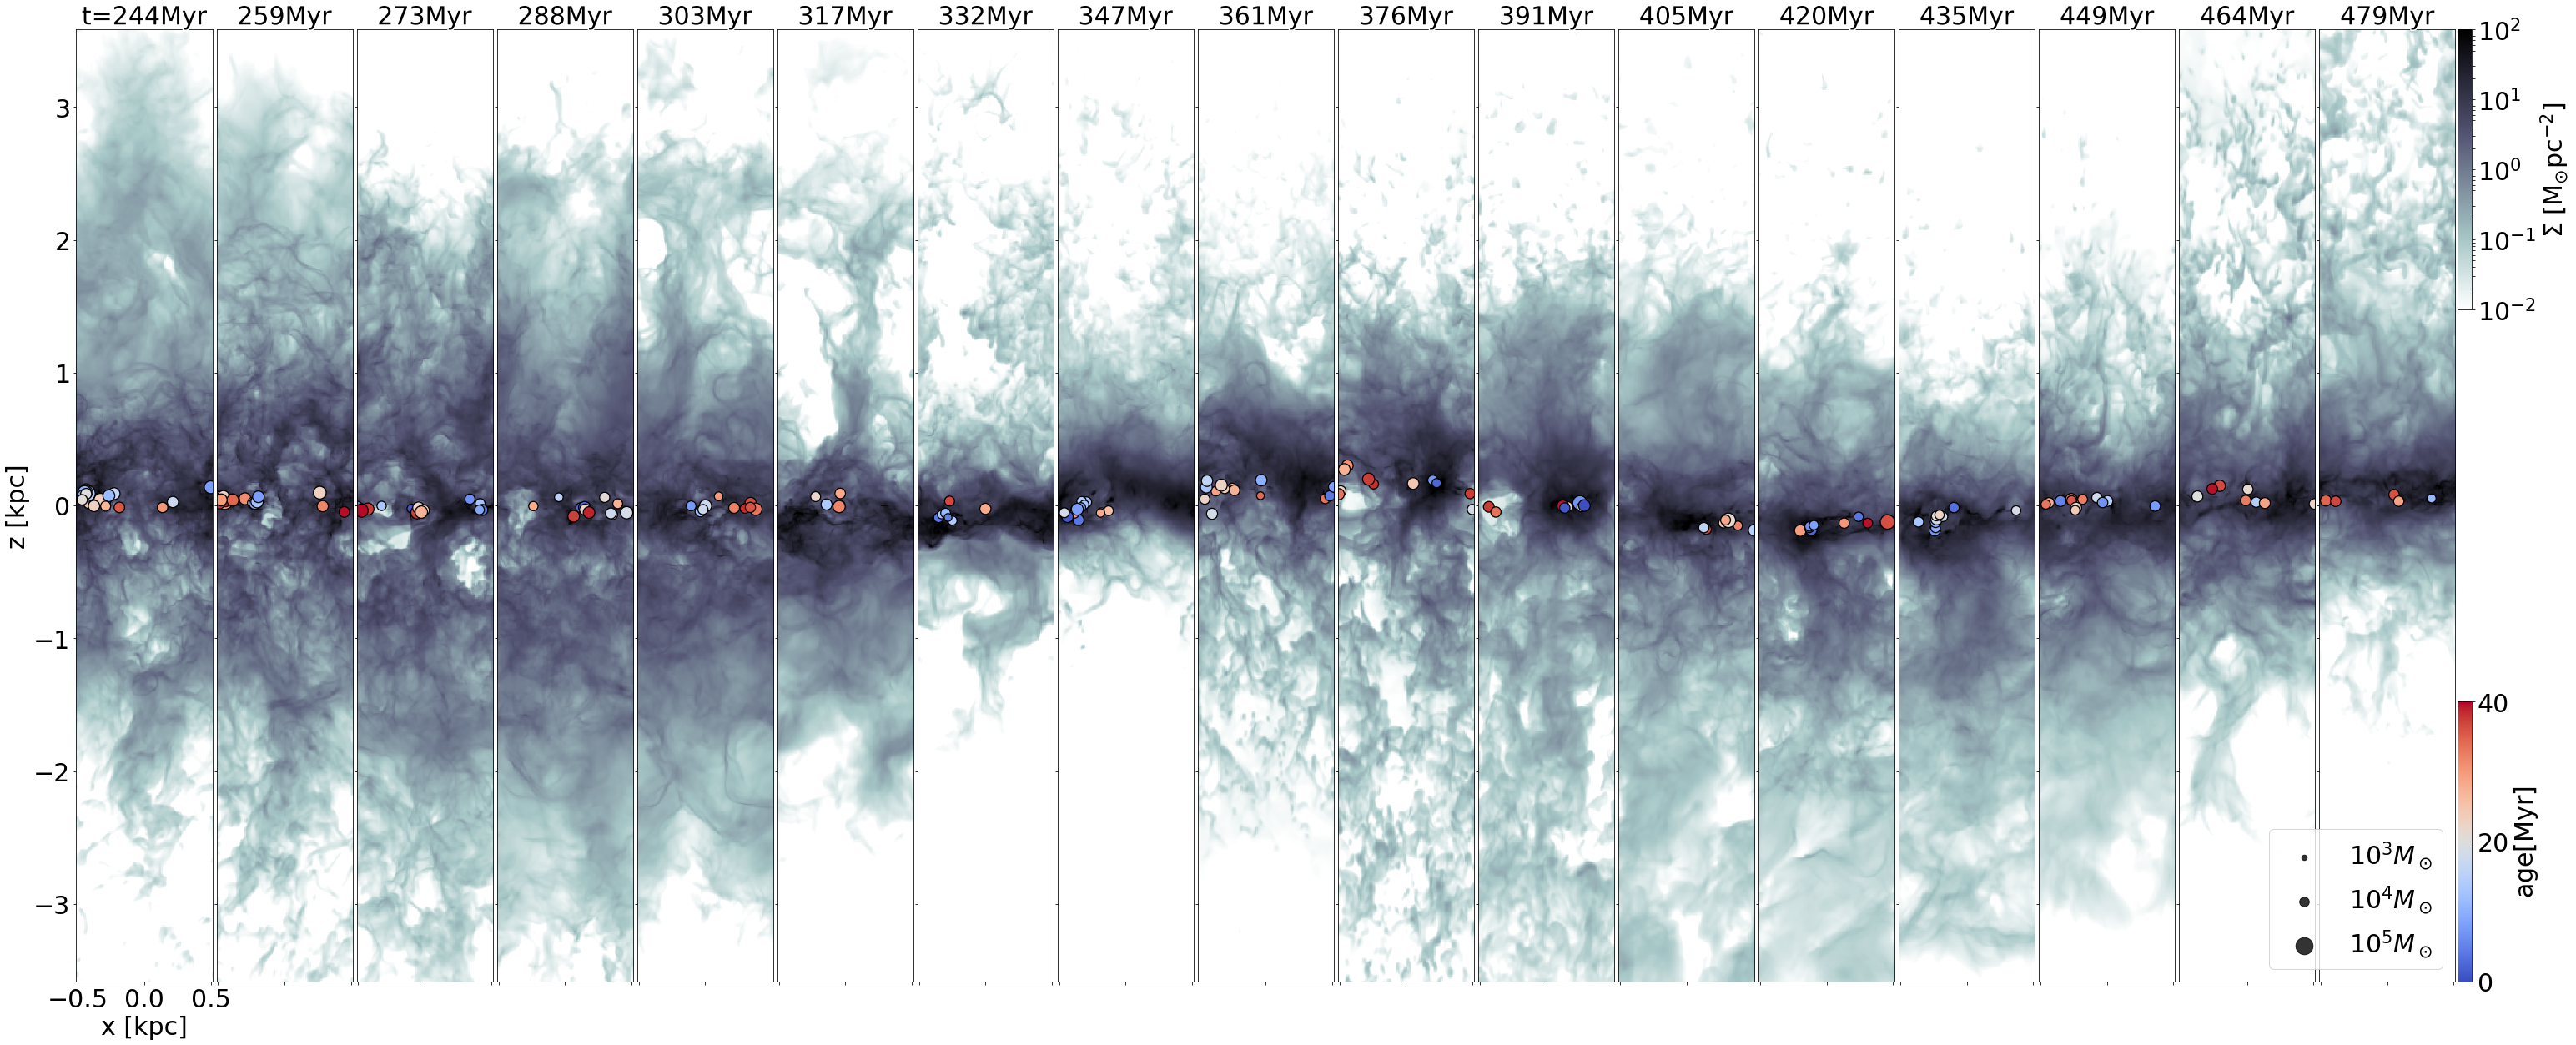

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
from matplotlib.colors import LogNorm
import cPickle as pickle
from pyathena.yt_analysis.scatter_sp import scatter_sp
import pyathena.yt_analysis.plot_projection as pproj

base='F:/yeongu/'
problem_id='R8_8pc_metal'

surfnames=[]
for itime in range(250,500,15):
    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))
    print itime
fig=plot_projection_all(surfnames,axis='y',runaway=False,iscal=4,norm_factor=0.5,pngfname='surf_%s_alpha1_5.png' % problem_id)